In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage
import seaborn as sns

## 필요 함수 정의

1. 데이터 분포 시각화

In [2]:
def plot_distribution(dataframe_name, columns_to_plot):
    num_columns = len(columns_to_plot)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    fig.suptitle("Distribution of Molecular Properties", fontsize=16)

    for i, column in enumerate(columns_to_plot):
        row_idx = i // 3
        col_idx = i % 3
        axes[row_idx, col_idx].hist(dataframe_name[column], bins=30, edgecolor='black')
        axes[row_idx, col_idx].set_xlabel(column)
        axes[row_idx, col_idx].set_ylabel("Frequency")

    # Adjust layout and spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    plt.show()

2. 데이터셋에 존재하는 atom별 개수 시각화

In [3]:
def plot_atom_counts(dataframe_name):
    atom_counts = {'C': 0, 'H': 0, 'N': 0, 'O': 0, 'P': 0, 'S': 0, 'F': 0, 'Cl': 0}

    for smiles in dataframe_name['Can_SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            elements = mol.GetAtoms()
            for element in elements:
                symbol = element.GetSymbol()
                if symbol in atom_counts:
                    atom_counts[symbol] += 1

    # Create a DataFrame to store the atom counts
    atom_counts_df = pd.DataFrame.from_dict(atom_counts, orient='index', columns=['Count'])

    # Reset the index to include the atom symbols as a column
    atom_counts_df.reset_index(inplace=True)
    atom_counts_df.rename(columns={'index': 'Atom'}, inplace=True)

    # Exclude 'C' and 'H' atoms from the count plot
    atom_counts_plot = atom_counts_df[~atom_counts_df['Atom'].isin(['C', 'H'])]

    # Plot the count plot
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Atom', y='Count', data=atom_counts_plot, palette='pastel')
    plt.xlabel('Atom')
    plt.ylabel('Count')
    plt.title('Atom Counts in the Molecules Dataset (Excluding C and H)')

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(int(height)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(ax.patches)

    plt.show()

3. Canonicalize 함수

In [4]:
def canonical_smiles(isomeric_smiles):
    mol = Chem.MolFromSmiles(isomeric_smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        return None

4. Data curation 함수

In [6]:
def curation(smiles):
    # Check for delocalized charged groups or stereochemistry in the SMILES
    delocal_charged = int('-' in smiles or '+' in smiles or '@' in smiles)

    # Convert SMILES to RDKit Mol object
    mol = Chem.MolFromSmiles(smiles)

    # Check for nitrogen with protons
    protic_N = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'N' and atom.GetNumImplicitHs() > 0:
            protic_N = 1
            break

    # Check for alcohol
    alcohol = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'O' and atom.GetNumImplicitHs() > 0:
            alcohol = 1
            break

    # Check for thiol
    thiol = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'S' and atom.GetNumImplicitHs() > 0:
            thiol = 1
            break

    # Check for PH
    PH = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'P' and atom.GetNumImplicitHs() > 0:
            PH = 1
            break

    # Check for three or four-membered rings
    ring_sizes = set(len(ring) for ring in Chem.GetSSSR(mol))
    small_ring = int(3 in ring_sizes or 4 in ring_sizes)

    # Check if the SMILES consists of only carbon atoms
    C_only = int(all(atom.GetSymbol() == 'C' for atom in mol.GetAtoms()))

    # Return the results as a tuple with six elements
    return delocal_charged, protic_N, alcohol, thiol, PH, small_ring, C_only


## 모든 csv 파일 하나의 DataFrame으로 concat

In [6]:
directory_path = './' ######## 추출한 csv 파일들이 있는 경로

csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

dataframes_list = []
for csv_file in csv_files:
    csv_file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(csv_file_path)
    dataframes_list.append(df)

merged_df = pd.concat(dataframes_list, ignore_index=True)


In [7]:
merged_df.head(3)

,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring
0,24,46225301,C16H12N4O2,292.29208,34,22,1.787810,-6.196032,-2.770119,3.425913,CC1=NN(C2=NC=C3C(=C12)C(=O)N(C3=O)C4=CC=CC=C4)C,Cc1nn(C)c2ncc3c(c12)C(=O)N(c1ccccc1)C3=O,0,0,0,0,0,0
1,39,46225638,C18H18O,250.33492,37,19,3.790826,-6.032764,-1.766019,4.266745,CC1=CC(=CC(=C1C)C)/C=C/C(=O)C2=CC=CC=C2,Cc1cc(/C=C/C(=O)c2ccccc2)cc(C)c1C,0,0,0,0,0,0
2,48,46225722,C15H11N3O4,297.26554,33,22,0.760276,-5.654526,-1.749692,3.904834,CC1=NC2=CC3=C(C=C2C(=O)N1/N=C/C4=CC=CO4)OCO3,Cc1nc2cc3c(cc2c(=O)n1/N=C/c1ccco1)OCO3,0,0,0,0,0,0


## Canonicalize

In [8]:
merged_df['Can_SMILES'] = merged_df['Isomeric_SMILES'].apply(canonical_smiles)

[05:06:15] WARNING: not removing hydrogen atom without neighbors


In [9]:
merged_df.columns

Index(['Unnamed: 0', 'i', 'molecular_formula', 'molecular_weight',
       'atom_count', 'heavy_atom_count', 'total_dipole_moment', 'homo', 'lumo',
       'gap', 'Isomeric_SMILES', 'Can_SMILES', 'delocal_charged', 'protic_N',
       'alcohol', 'thiol', 'PH', 'small_ring'],
      dtype='object')

## Data 분포 확인

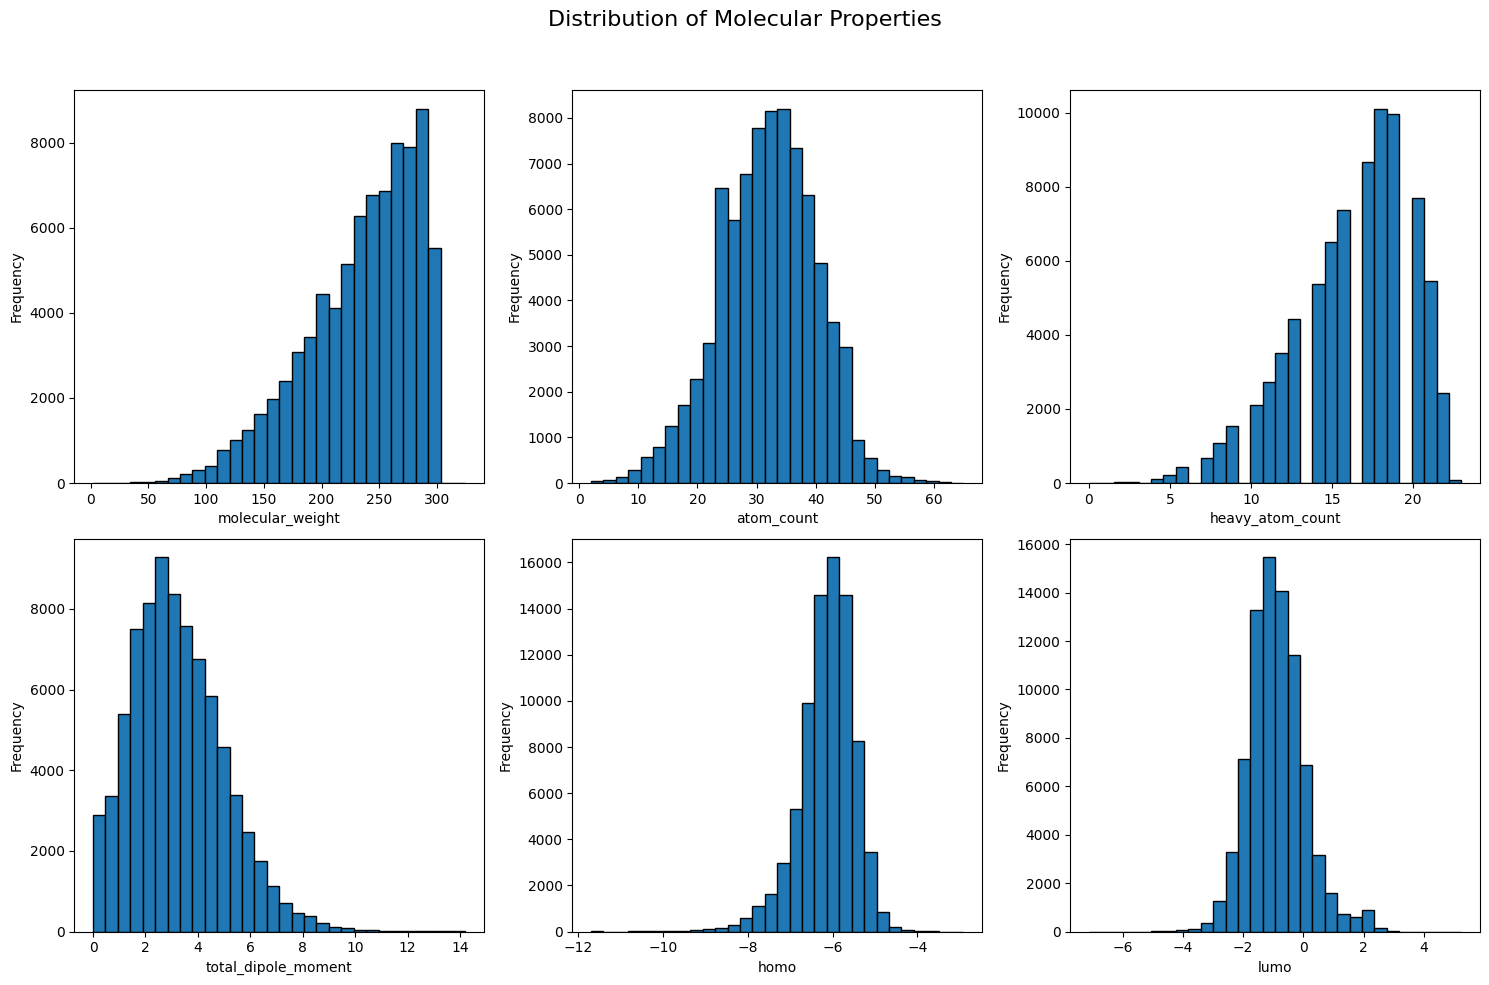

In [10]:
plot_distribution(merged_df, ["molecular_weight", "atom_count", "heavy_atom_count", "total_dipole_moment", "homo", "lumo"])

[17:37:32] WARNING: not removing hydrogen atom without neighbors


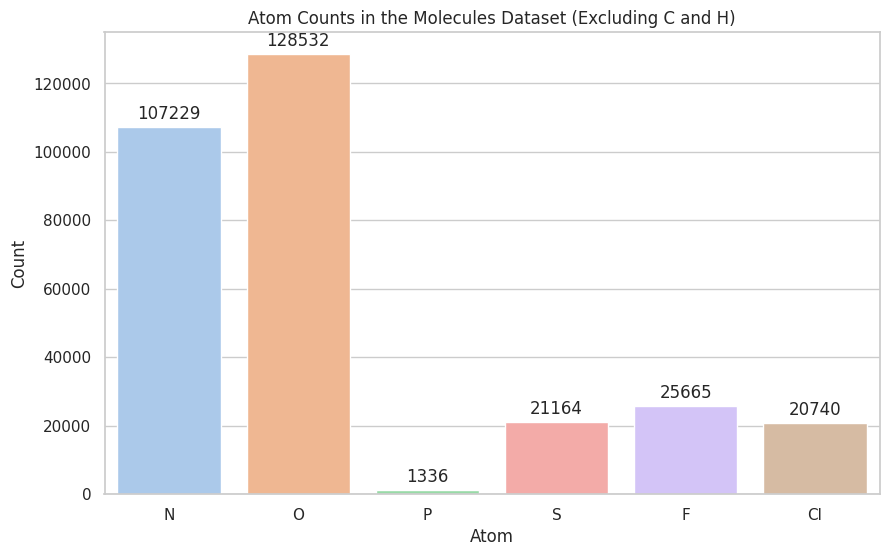

In [11]:
plot_atom_counts(merged_df)

## Curation

__1. delocalized electron의 이동에 의해 charge separation된 분자 제외(nucleophilicity)__<br>
__2. stereochemistry 표현된 분자 제외__<br>
__3. protic 물질 제외__<br>
- primary, secondary amine<br>
- alcohol<br>
- thiol<br>
- P : # 결합 수 3, 5 가 아니면 H가 붙으므로 제외<br>

__4. 불안정한 물질 제외__<br>
- 3-membered ring<br>
- 4-membered ring<br>

__5. bridged molecule 제거__<br>
__6. C로만 이뤄진 분자 제거__<br>


In [15]:
merged_df[['delocal_charged', 'protic_N', 'alcohol', 'thiol', 'PH', 'small_ring', 'C_only']] = merged_df['Can_SMILES'].apply(curation).tolist()

[17:40:35] WARNING: not removing hydrogen atom without neighbors


In [17]:
merged_df

,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
0,24,46225301,C16H12N4O2,292.29208,34,22,1.787810,-6.196032,-2.770119,3.425913,CC1=NN(C2=NC=C3C(=C12)C(=O)N(C3=O)C4=CC=CC=C4)C,Cc1nn(C)c2ncc3c(c12)C(=O)N(c1ccccc1)C3=O,0,0,0,0,0,0,0
1,39,46225638,C18H18O,250.33492,37,19,3.790826,-6.032764,-1.766019,4.266745,CC1=CC(=CC(=C1C)C)/C=C/C(=O)C2=CC=CC=C2,Cc1cc(/C=C/C(=O)c2ccccc2)cc(C)c1C,0,0,0,0,0,0,0
2,48,46225722,C15H11N3O4,297.26554,33,22,0.760276,-5.654526,-1.749692,3.904834,CC1=NC2=CC3=C(C=C2C(=O)N1/N=C/C4=CC=CO4)OCO3,Cc1nc2cc3c(cc2c(=O)n1/N=C/c1ccco1)OCO3,0,0,0,0,0,0,0
3,49,46225741,C13H8N2O,208.21542,24,16,2.801039,-5.406902,-0.835390,4.571513,C1=CC=C2C(=C1)C3=C(C4=C2OC=C4)N=CN3,c1ccc2c(c1)c1[nH]cnc1c1ccoc21,0,0,0,0,0,0,0
4,52,46225750,C15H11N3O,249.26734,30,19,3.728483,-5.145673,-1.425877,3.719796,CC1=CC=CC2=NC3=C(N12)NC(=O)C4=CC=CC=C43,Cc1cccc2nc3c4ccccc4c(=O)[nH]c3n12,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80496,351679,118774686,C14H16N4O2,272.30244,36,20,2.525573,-5.991947,-0.386402,5.605545,C1CN(CC1OC2=CC=CC=C2)C(=O)CN3C=CN=N3,O=C(Cn1ccnn1)N1CCC(Oc2ccccc2)C1,0,0,0,0,0,0,0
80497,351680,118774692,C16H18N4O,282.34032,39,21,3.820336,-6.432771,-0.955120,5.477652,CC1=NOC(=N1)CN2CCC(CC2)(C#N)C3=CC=CC=C3,Cc1noc(CN2CCC(C#N)(c3ccccc3)CC2)n1,0,0,0,0,0,0,0
80498,351696,118774799,C12H20N4OS,268.37840,38,18,2.216076,-5.496700,-0.005442,5.491258,CSCCN1CCN(CC1)C(=O)CN2C=CC=N2,CSCCN1CCN(C(=O)Cn2cccn2)CC1,0,0,0,0,0,0,0
80499,351697,118774803,C13H22N6,262.35398,41,19,7.718982,-5.831400,0.157826,5.989226,CCCN1C=NN=C1CN(C)CC2=NN(C=C2)CC,CCCn1cnnc1CN(C)Cc1ccn(CC)n1,0,0,0,0,0,0,0


In [18]:
print('delocal_charged: ', merged_df['delocal_charged'].sum())
print('protic_N: ', merged_df['protic_N'].sum())
print('alcohol: ', merged_df['alcohol'].sum())
print('thiol: ', merged_df['thiol'].sum())
print('PH: ', merged_df['PH'].sum())
print('small_ring: ', merged_df['small_ring'].sum())
print('C_only: ', merged_df['C_only'].sum())


delocal_charged:  0
protic_N:  0
alcohol:  0
thiol:  0
PH:  0
small_ring:  0
C_only:  2183


## Curation된 분자 추출 및 분포 시각화

In [19]:
new_df = merged_df[(merged_df['protic_N'] == 0) & (merged_df['delocal_charged'] == 0) & (merged_df['alcohol'] == 0) & (merged_df['thiol'] == 0) & (merged_df['PH'] == 0) & (merged_df['small_ring'] == 0) & (merged_df['C_only'] == 0)].copy()

In [20]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78318 entries, 0 to 80500
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           78318 non-null  int64  
 1   i                    78318 non-null  int64  
 2   molecular_formula    78318 non-null  object 
 3   molecular_weight     78318 non-null  float64
 4   atom_count           78318 non-null  int64  
 5   heavy_atom_count     78318 non-null  int64  
 6   total_dipole_moment  78318 non-null  float64
 7   homo                 78318 non-null  float64
 8   lumo                 78318 non-null  float64
 9   gap                  78318 non-null  float64
 10  Isomeric_SMILES      78318 non-null  object 
 11  Can_SMILES           78318 non-null  object 
 12  delocal_charged      78318 non-null  int64  
 13  protic_N             78318 non-null  int64  
 14  alcohol              78318 non-null  int64  
 15  thiol                78318 non-null  int6

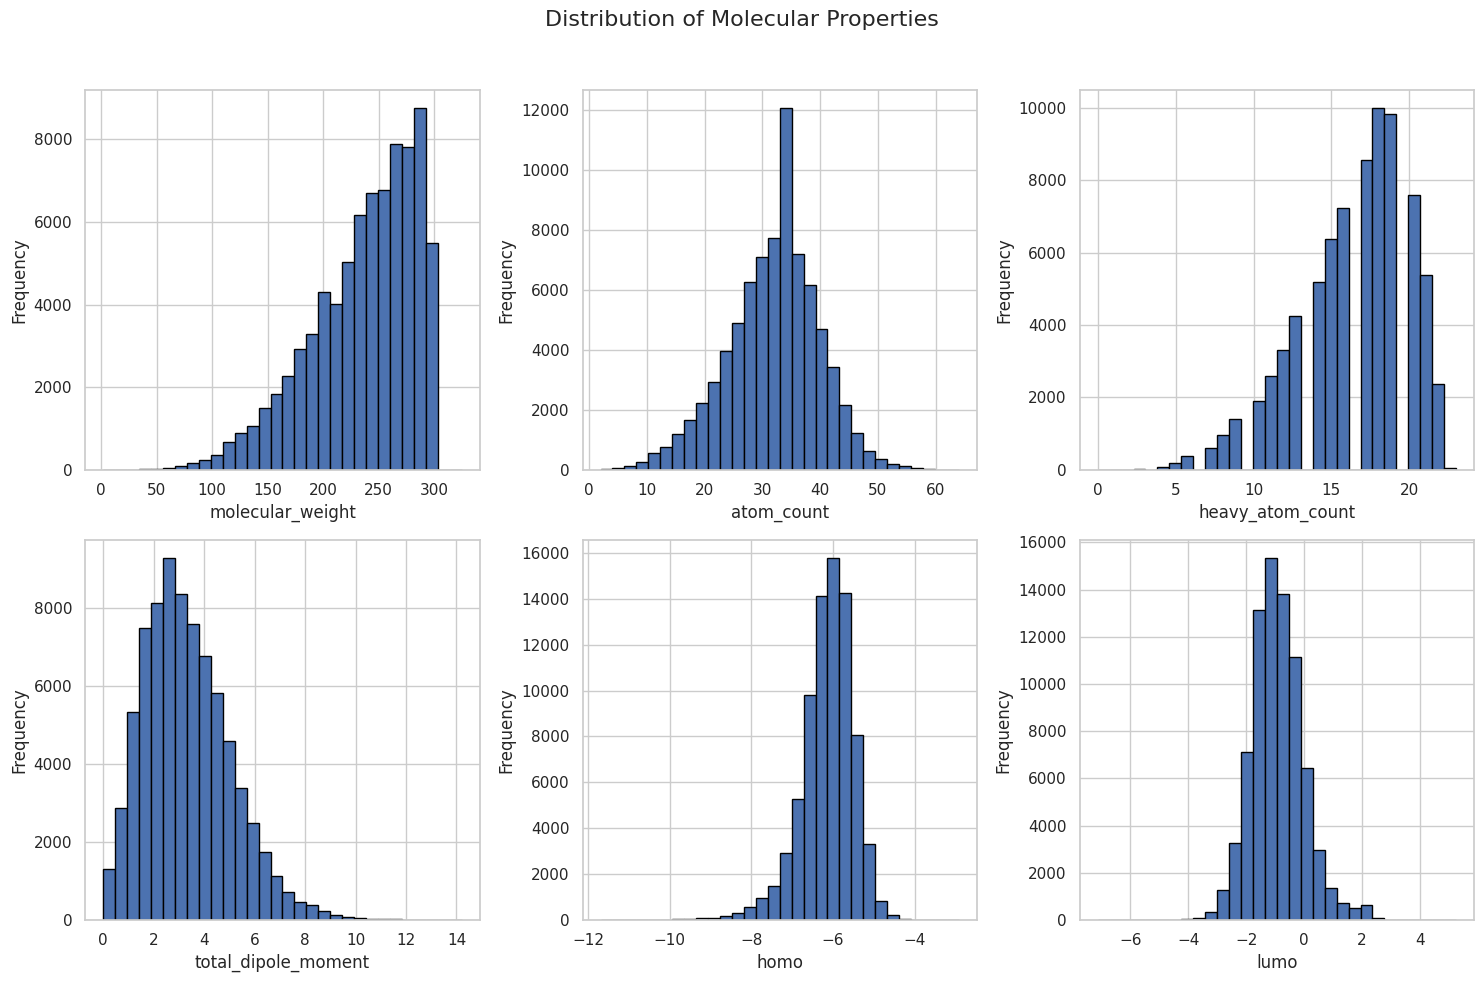

In [21]:
plot_distribution(new_df, ["molecular_weight", "atom_count", "heavy_atom_count", "total_dipole_moment", "homo", "lumo"])

[17:42:39] WARNING: not removing hydrogen atom without neighbors


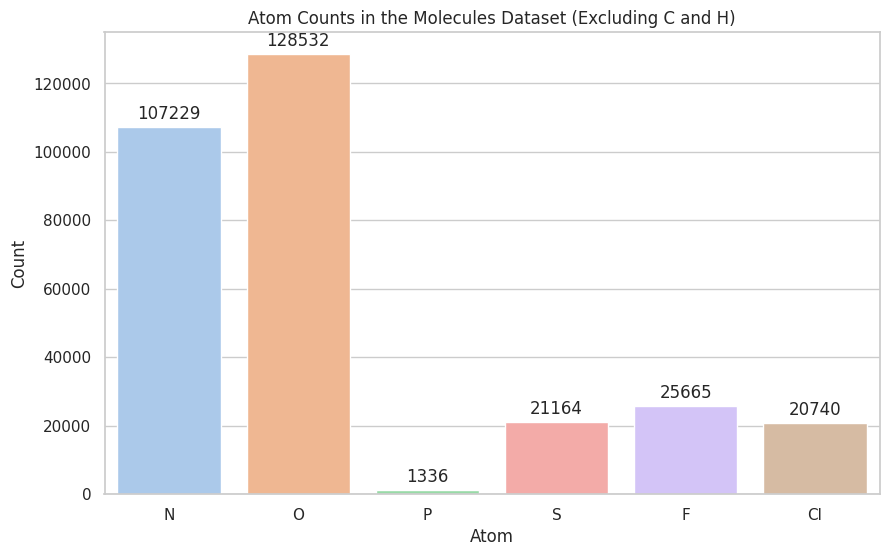

In [22]:
plot_atom_counts(new_df)

In [26]:
duplicates = new_df.duplicated(subset='Can_SMILES', keep=False)
duplicated_rows = new_df[duplicates]
duplicated_rows

,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
42855,55321,90000195,C10H14O,163.297663,25,11,1.325327,-5.681737,0.048980,5.730718,[2H]C1=C(C(=C(C(=C1C(C([2H])[2H])(C([2H])([2H]...,[2H]Oc1c([2H])c([2H])c(C(C([2H])[2H])(C([2H])(...,0,0,0,0,0,0,0
42856,55326,90000251,C20H15NO,285.339200,37,22,1.806710,-5.202817,-1.178253,4.024564,C1=CC=C(C=C1)C2=CC3=CC=CC=C3ON2C4=CC=CC=C4,C1=C(c2ccccc2)N(c2ccccc2)Oc2ccccc21,0,0,0,0,0,0,0
42857,55336,90000352,C12H16O3,208.253640,31,15,1.642505,-5.692622,-0.413613,5.279009,CCOC(OC)OC1=CC=C(C=C1)C=C,C=Cc1ccc(OC(OC)OCC)cc1,0,0,0,0,0,0,0
42858,55337,90000353,C12H16O3,208.253640,31,15,1.367726,-5.572892,-0.394565,5.178327,COCCOCOC1=CC=C(C=C1)C=C,C=Cc1ccc(OCOCCOC)cc1,0,0,0,0,0,0,0
42859,55338,90000356,C12H16O3,208.253640,31,15,0.884703,-5.665410,-0.424498,5.240913,CC(OC)OCOC1=CC=C(C=C1)C=C,C=Cc1ccc(OCOC(C)OC)cc1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61906,88366,90024968,C17H24O4,292.370060,45,21,2.544130,-6.340253,-0.473478,5.866775,CCC(CC)CCC(=O)OC1=CC=CC=C1OC(=O)CC,CCC(=O)Oc1ccccc1OC(=O)CCC(CC)CC,0,0,0,0,0,0,0
61907,88367,90024970,C9H8ClN3O2,225.631720,23,15,1.938690,-6.419166,-2.171469,4.247697,CC1=C(N=C2N1N=C(C=C2)Cl)C(=O)OC,COC(=O)c1nc2ccc(Cl)nn2c1C,0,0,0,0,0,0,0
61908,88371,90024981,C15H20O4,264.316900,39,19,3.071294,-6.272224,-0.457151,5.815073,CCCCCCC(=O)OC1=CC=CC=C1OC(=O)C,CCCCCCC(=O)Oc1ccccc1OC(C)=O,0,0,0,0,0,0,0
61909,88374,90024993,C15H20O4,264.316900,39,19,2.752145,-6.171542,-0.582324,5.589218,CCCC(=O)OC1=CC=CC=C1OC(=O)CC(C)C,CCCC(=O)Oc1ccccc1OC(=O)CC(C)C,0,0,0,0,0,0,0


In [27]:
df_unique = new_df.drop_duplicates(subset='Can_SMILES', keep='first')
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77265 entries, 0 to 80500
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           77265 non-null  int64  
 1   i                    77265 non-null  int64  
 2   molecular_formula    77265 non-null  object 
 3   molecular_weight     77265 non-null  float64
 4   atom_count           77265 non-null  int64  
 5   heavy_atom_count     77265 non-null  int64  
 6   total_dipole_moment  77265 non-null  float64
 7   homo                 77265 non-null  float64
 8   lumo                 77265 non-null  float64
 9   gap                  77265 non-null  float64
 10  Isomeric_SMILES      77265 non-null  object 
 11  Can_SMILES           77265 non-null  object 
 12  delocal_charged      77265 non-null  int64  
 13  protic_N             77265 non-null  int64  
 14  alcohol              77265 non-null  int64  
 15  thiol                77265 non-null  int6

In [29]:
df_unique

,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
0,24,46225301,C16H12N4O2,292.29208,34,22,1.787810,-6.196032,-2.770119,3.425913,CC1=NN(C2=NC=C3C(=C12)C(=O)N(C3=O)C4=CC=CC=C4)C,Cc1nn(C)c2ncc3c(c12)C(=O)N(c1ccccc1)C3=O,0,0,0,0,0,0,0
1,39,46225638,C18H18O,250.33492,37,19,3.790826,-6.032764,-1.766019,4.266745,CC1=CC(=CC(=C1C)C)/C=C/C(=O)C2=CC=CC=C2,Cc1cc(/C=C/C(=O)c2ccccc2)cc(C)c1C,0,0,0,0,0,0,0
2,48,46225722,C15H11N3O4,297.26554,33,22,0.760276,-5.654526,-1.749692,3.904834,CC1=NC2=CC3=C(C=C2C(=O)N1/N=C/C4=CC=CO4)OCO3,Cc1nc2cc3c(cc2c(=O)n1/N=C/c1ccco1)OCO3,0,0,0,0,0,0,0
3,49,46225741,C13H8N2O,208.21542,24,16,2.801039,-5.406902,-0.835390,4.571513,C1=CC=C2C(=C1)C3=C(C4=C2OC=C4)N=CN3,c1ccc2c(c1)c1[nH]cnc1c1ccoc21,0,0,0,0,0,0,0
4,52,46225750,C15H11N3O,249.26734,30,19,3.728483,-5.145673,-1.425877,3.719796,CC1=CC=CC2=NC3=C(N12)NC(=O)C4=CC=CC=C43,Cc1cccc2nc3c4ccccc4c(=O)[nH]c3n12,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80496,351679,118774686,C14H16N4O2,272.30244,36,20,2.525573,-5.991947,-0.386402,5.605545,C1CN(CC1OC2=CC=CC=C2)C(=O)CN3C=CN=N3,O=C(Cn1ccnn1)N1CCC(Oc2ccccc2)C1,0,0,0,0,0,0,0
80497,351680,118774692,C16H18N4O,282.34032,39,21,3.820336,-6.432771,-0.955120,5.477652,CC1=NOC(=N1)CN2CCC(CC2)(C#N)C3=CC=CC=C3,Cc1noc(CN2CCC(C#N)(c3ccccc3)CC2)n1,0,0,0,0,0,0,0
80498,351696,118774799,C12H20N4OS,268.37840,38,18,2.216076,-5.496700,-0.005442,5.491258,CSCCN1CCN(CC1)C(=O)CN2C=CC=N2,CSCCN1CCN(C(=O)Cn2cccn2)CC1,0,0,0,0,0,0,0
80499,351697,118774803,C13H22N6,262.35398,41,19,7.718982,-5.831400,0.157826,5.989226,CCCN1C=NN=C1CN(C)CC2=NN(C=C2)CC,CCCn1cnnc1CN(C)Cc1ccn(CC)n1,0,0,0,0,0,0,0


### SMILES 내에 H 혹은 . 있는 분자 제거

In [ ]:
filtered_indices = df_unique[df_unique['Can_SMILES'].str.contains('H|\.')].index

df_unique.drop(filtered_indices, inplace=True)

### CSV로 저장

In [28]:
df_unique.to_csv('./PubChemQC_93683.csv')  #######파일명 수정 "PubChemQC__(new_df의 데이터 개수)"

## 재확인

In [4]:
directory_path = './recheck/' ######## 추출한 csv 파일들이 있는 경로

csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

dataframes_list = []
for csv_file in csv_files:
    csv_file_path = os.path.join(directory_path, csv_file)
    df = pd.read_csv(csv_file_path)
    dataframes_list.append(df)

merged_df = pd.concat(dataframes_list, ignore_index=True)

In [5]:
merged_df

,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
0,24,46225301,C16H12N4O2,292.29208,34,22,1.787810,-6.196032,-2.770119,3.425913,CC1=NN(C2=NC=C3C(=C12)C(=O)N(C3=O)C4=CC=CC=C4)C,Cc1nn(C)c2ncc3c(c12)C(=O)N(c1ccccc1)C3=O,0,0,0,0,0,0,NaN
1,39,46225638,C18H18O,250.33492,37,19,3.790826,-6.032764,-1.766019,4.266745,CC1=CC(=CC(=C1C)C)/C=C/C(=O)C2=CC=CC=C2,Cc1cc(/C=C/C(=O)c2ccccc2)cc(C)c1C,0,0,0,0,0,0,NaN
2,48,46225722,C15H11N3O4,297.26554,33,22,0.760276,-5.654526,-1.749692,3.904834,CC1=NC2=CC3=C(C=C2C(=O)N1/N=C/C4=CC=CO4)OCO3,Cc1nc2cc3c(cc2c(=O)n1/N=C/c1ccco1)OCO3,0,0,0,0,0,0,NaN
3,49,46225741,C13H8N2O,208.21542,24,16,2.801039,-5.406902,-0.835390,4.571513,C1=CC=C2C(=C1)C3=C(C4=C2OC=C4)N=CN3,c1ccc2c(c1)c1[nH]cnc1c1ccoc21,0,0,0,0,0,0,NaN
4,52,46225750,C15H11N3O,249.26734,30,19,3.728483,-5.145673,-1.425877,3.719796,CC1=CC=CC2=NC3=C(N12)NC(=O)C4=CC=CC=C43,Cc1cccc2nc3c4ccccc4c(=O)[nH]c3n12,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108283,351679,118774686,C14H16N4O2,272.30244,36,20,2.525573,-5.991947,-0.386402,5.605545,C1CN(CC1OC2=CC=CC=C2)C(=O)CN3C=CN=N3,O=C(Cn1ccnn1)N1CCC(Oc2ccccc2)C1,0,0,0,0,0,0,NaN
108284,351680,118774692,C16H18N4O,282.34032,39,21,3.820336,-6.432771,-0.955120,5.477652,CC1=NOC(=N1)CN2CCC(CC2)(C#N)C3=CC=CC=C3,Cc1noc(CN2CCC(C#N)(c3ccccc3)CC2)n1,0,0,0,0,0,0,NaN
108285,351696,118774799,C12H20N4OS,268.37840,38,18,2.216076,-5.496700,-0.005442,5.491258,CSCCN1CCN(CC1)C(=O)CN2C=CC=N2,CSCCN1CCN(C(=O)Cn2cccn2)CC1,0,0,0,0,0,0,NaN
108286,351697,118774803,C13H22N6,262.35398,41,19,7.718982,-5.831400,0.157826,5.989226,CCCN1C=NN=C1CN(C)CC2=NN(C=C2)CC,CCCn1cnnc1CN(C)Cc1ccn(CC)n1,0,0,0,0,0,0,NaN


In [7]:
merged_df[['delocal_charged', 'protic_N', 'alcohol', 'thiol', 'PH', 'small_ring', 'C_only']] = merged_df['Can_SMILES'].apply(curation).tolist()
merged_df

[17:51:28] WARNING: not removing hydrogen atom without neighbors
[17:51:30] WARNING: not removing hydrogen atom without neighbors
[17:51:31] WARNING: not removing hydrogen atom without neighbors


,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
0,24,46225301,C16H12N4O2,292.29208,34,22,1.787810,-6.196032,-2.770119,3.425913,CC1=NN(C2=NC=C3C(=C12)C(=O)N(C3=O)C4=CC=CC=C4)C,Cc1nn(C)c2ncc3c(c12)C(=O)N(c1ccccc1)C3=O,0,0,0,0,0,0,0
1,39,46225638,C18H18O,250.33492,37,19,3.790826,-6.032764,-1.766019,4.266745,CC1=CC(=CC(=C1C)C)/C=C/C(=O)C2=CC=CC=C2,Cc1cc(/C=C/C(=O)c2ccccc2)cc(C)c1C,0,0,0,0,0,0,0
2,48,46225722,C15H11N3O4,297.26554,33,22,0.760276,-5.654526,-1.749692,3.904834,CC1=NC2=CC3=C(C=C2C(=O)N1/N=C/C4=CC=CO4)OCO3,Cc1nc2cc3c(cc2c(=O)n1/N=C/c1ccco1)OCO3,0,0,0,0,0,0,0
3,49,46225741,C13H8N2O,208.21542,24,16,2.801039,-5.406902,-0.835390,4.571513,C1=CC=C2C(=C1)C3=C(C4=C2OC=C4)N=CN3,c1ccc2c(c1)c1[nH]cnc1c1ccoc21,0,0,0,0,0,0,0
4,52,46225750,C15H11N3O,249.26734,30,19,3.728483,-5.145673,-1.425877,3.719796,CC1=CC=CC2=NC3=C(N12)NC(=O)C4=CC=CC=C43,Cc1cccc2nc3c4ccccc4c(=O)[nH]c3n12,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108283,351679,118774686,C14H16N4O2,272.30244,36,20,2.525573,-5.991947,-0.386402,5.605545,C1CN(CC1OC2=CC=CC=C2)C(=O)CN3C=CN=N3,O=C(Cn1ccnn1)N1CCC(Oc2ccccc2)C1,0,0,0,0,0,0,0
108284,351680,118774692,C16H18N4O,282.34032,39,21,3.820336,-6.432771,-0.955120,5.477652,CC1=NOC(=N1)CN2CCC(CC2)(C#N)C3=CC=CC=C3,Cc1noc(CN2CCC(C#N)(c3ccccc3)CC2)n1,0,0,0,0,0,0,0
108285,351696,118774799,C12H20N4OS,268.37840,38,18,2.216076,-5.496700,-0.005442,5.491258,CSCCN1CCN(CC1)C(=O)CN2C=CC=N2,CSCCN1CCN(C(=O)Cn2cccn2)CC1,0,0,0,0,0,0,0
108286,351697,118774803,C13H22N6,262.35398,41,19,7.718982,-5.831400,0.157826,5.989226,CCCN1C=NN=C1CN(C)CC2=NN(C=C2)CC,CCCn1cnnc1CN(C)Cc1ccn(CC)n1,0,0,0,0,0,0,0


In [8]:
print('delocal_charged: ', merged_df['delocal_charged'].sum())
print('protic_N: ', merged_df['protic_N'].sum())
print('alcohol: ', merged_df['alcohol'].sum())
print('thiol: ', merged_df['thiol'].sum())
print('PH: ', merged_df['PH'].sum())
print('small_ring: ', merged_df['small_ring'].sum())
print('C_only: ', merged_df['C_only'].sum())

delocal_charged:  0
protic_N:  0
alcohol:  0
thiol:  0
PH:  0
small_ring:  0
C_only:  2183


In [9]:
new_df = merged_df[(merged_df['protic_N'] == 0) & (merged_df['delocal_charged'] == 0) & (merged_df['alcohol'] == 0) & (merged_df['thiol'] == 0) & (merged_df['PH'] == 0) & (merged_df['small_ring'] == 0) & (merged_df['C_only'] == 0)].copy()
new_df

,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
0,24,46225301,C16H12N4O2,292.29208,34,22,1.787810,-6.196032,-2.770119,3.425913,CC1=NN(C2=NC=C3C(=C12)C(=O)N(C3=O)C4=CC=CC=C4)C,Cc1nn(C)c2ncc3c(c12)C(=O)N(c1ccccc1)C3=O,0,0,0,0,0,0,0
1,39,46225638,C18H18O,250.33492,37,19,3.790826,-6.032764,-1.766019,4.266745,CC1=CC(=CC(=C1C)C)/C=C/C(=O)C2=CC=CC=C2,Cc1cc(/C=C/C(=O)c2ccccc2)cc(C)c1C,0,0,0,0,0,0,0
2,48,46225722,C15H11N3O4,297.26554,33,22,0.760276,-5.654526,-1.749692,3.904834,CC1=NC2=CC3=C(C=C2C(=O)N1/N=C/C4=CC=CO4)OCO3,Cc1nc2cc3c(cc2c(=O)n1/N=C/c1ccco1)OCO3,0,0,0,0,0,0,0
3,49,46225741,C13H8N2O,208.21542,24,16,2.801039,-5.406902,-0.835390,4.571513,C1=CC=C2C(=C1)C3=C(C4=C2OC=C4)N=CN3,c1ccc2c(c1)c1[nH]cnc1c1ccoc21,0,0,0,0,0,0,0
4,52,46225750,C15H11N3O,249.26734,30,19,3.728483,-5.145673,-1.425877,3.719796,CC1=CC=CC2=NC3=C(N12)NC(=O)C4=CC=CC=C43,Cc1cccc2nc3c4ccccc4c(=O)[nH]c3n12,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108283,351679,118774686,C14H16N4O2,272.30244,36,20,2.525573,-5.991947,-0.386402,5.605545,C1CN(CC1OC2=CC=CC=C2)C(=O)CN3C=CN=N3,O=C(Cn1ccnn1)N1CCC(Oc2ccccc2)C1,0,0,0,0,0,0,0
108284,351680,118774692,C16H18N4O,282.34032,39,21,3.820336,-6.432771,-0.955120,5.477652,CC1=NOC(=N1)CN2CCC(CC2)(C#N)C3=CC=CC=C3,Cc1noc(CN2CCC(C#N)(c3ccccc3)CC2)n1,0,0,0,0,0,0,0
108285,351696,118774799,C12H20N4OS,268.37840,38,18,2.216076,-5.496700,-0.005442,5.491258,CSCCN1CCN(CC1)C(=O)CN2C=CC=N2,CSCCN1CCN(C(=O)Cn2cccn2)CC1,0,0,0,0,0,0,0
108286,351697,118774803,C13H22N6,262.35398,41,19,7.718982,-5.831400,0.157826,5.989226,CCCN1C=NN=C1CN(C)CC2=NN(C=C2)CC,CCCn1cnnc1CN(C)Cc1ccn(CC)n1,0,0,0,0,0,0,0


In [10]:
df_unique = new_df.drop_duplicates(subset='Can_SMILES', keep='first')
df_unique

,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
0,24,46225301,C16H12N4O2,292.29208,34,22,1.787810,-6.196032,-2.770119,3.425913,CC1=NN(C2=NC=C3C(=C12)C(=O)N(C3=O)C4=CC=CC=C4)C,Cc1nn(C)c2ncc3c(c12)C(=O)N(c1ccccc1)C3=O,0,0,0,0,0,0,0
1,39,46225638,C18H18O,250.33492,37,19,3.790826,-6.032764,-1.766019,4.266745,CC1=CC(=CC(=C1C)C)/C=C/C(=O)C2=CC=CC=C2,Cc1cc(/C=C/C(=O)c2ccccc2)cc(C)c1C,0,0,0,0,0,0,0
2,48,46225722,C15H11N3O4,297.26554,33,22,0.760276,-5.654526,-1.749692,3.904834,CC1=NC2=CC3=C(C=C2C(=O)N1/N=C/C4=CC=CO4)OCO3,Cc1nc2cc3c(cc2c(=O)n1/N=C/c1ccco1)OCO3,0,0,0,0,0,0,0
3,49,46225741,C13H8N2O,208.21542,24,16,2.801039,-5.406902,-0.835390,4.571513,C1=CC=C2C(=C1)C3=C(C4=C2OC=C4)N=CN3,c1ccc2c(c1)c1[nH]cnc1c1ccoc21,0,0,0,0,0,0,0
4,52,46225750,C15H11N3O,249.26734,30,19,3.728483,-5.145673,-1.425877,3.719796,CC1=CC=CC2=NC3=C(N12)NC(=O)C4=CC=CC=C43,Cc1cccc2nc3c4ccccc4c(=O)[nH]c3n12,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108283,351679,118774686,C14H16N4O2,272.30244,36,20,2.525573,-5.991947,-0.386402,5.605545,C1CN(CC1OC2=CC=CC=C2)C(=O)CN3C=CN=N3,O=C(Cn1ccnn1)N1CCC(Oc2ccccc2)C1,0,0,0,0,0,0,0
108284,351680,118774692,C16H18N4O,282.34032,39,21,3.820336,-6.432771,-0.955120,5.477652,CC1=NOC(=N1)CN2CCC(CC2)(C#N)C3=CC=CC=C3,Cc1noc(CN2CCC(C#N)(c3ccccc3)CC2)n1,0,0,0,0,0,0,0
108285,351696,118774799,C12H20N4OS,268.37840,38,18,2.216076,-5.496700,-0.005442,5.491258,CSCCN1CCN(CC1)C(=O)CN2C=CC=N2,CSCCN1CCN(C(=O)Cn2cccn2)CC1,0,0,0,0,0,0,0
108286,351697,118774803,C13H22N6,262.35398,41,19,7.718982,-5.831400,0.157826,5.989226,CCCN1C=NN=C1CN(C)CC2=NN(C=C2)CC,CCCn1cnnc1CN(C)Cc1ccn(CC)n1,0,0,0,0,0,0,0


In [11]:
filtered_df_withH= df_unique[df_unique['Can_SMILES'].str.contains('H')]
filtered_df_withH

,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
3,49,46225741,C13H8N2O,208.215420,24,16,2.801039,-5.406902,-0.835390,4.571513,C1=CC=C2C(=C1)C3=C(C4=C2OC=C4)N=CN3,c1ccc2c(c1)c1[nH]cnc1c1ccoc21,0,0,0,0,0,0,0
4,52,46225750,C15H11N3O,249.267340,30,19,3.728483,-5.145673,-1.425877,3.719796,CC1=CC=CC2=NC3=C(N12)NC(=O)C4=CC=CC=C43,Cc1cccc2nc3c4ccccc4c(=O)[nH]c3n12,0,0,0,0,0,0,0
5,53,46225751,C14H8ClN3O,269.685820,27,19,1.888732,-5.431392,-1.771461,3.659931,C1=CC=C2C(=C1)C3=C(NC2=O)N4C=C(C=CC4=N3)Cl,O=c1[nH]c2c(nc3ccc(Cl)cn32)c2ccccc12,0,0,0,0,0,0,0
6,59,46225772,C14H8ClN3O,269.685820,27,19,1.596444,-5.366085,-1.760577,3.605509,C1=CC=C2C(=C1)C3=C(NC2=O)N4C=CC(=CC4=N3)Cl,O=c1[nH]c2c(nc3cc(Cl)ccn32)c2ccccc12,0,0,0,0,0,0,0
7,61,46225777,C16H13N3O,263.293920,33,20,4.340128,-5.050433,-1.322473,3.727960,CC1=CC2=NC3=C(N2C(=C1)C)NC(=O)C4=CC=CC=C43,Cc1cc(C)n2c(c1)nc1c3ccccc3c(=O)[nH]c12,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108277,351630,118774196,C14H15FN4S,290.359103,35,20,4.573958,-5.670853,-1.115667,4.555186,CC1=NN=C(S1)CN(C)CC2=CC3=C(N2)C=CC(=C3)F,Cc1nnc(CN(C)Cc2cc3cc(F)ccc3[nH]2)s1,0,0,0,0,0,0,0
108278,351642,118774289,C13H24N4O,252.355860,42,18,4.871013,-5.425950,0.702054,6.128004,CC1=C(C(=NN1)C)CCN(C)C(C)C(=O)N(C)C,Cc1n[nH]c(C)c1CCN(C)C(C)C(=O)N(C)C,0,0,0,0,0,0,0
108279,351643,118774311,C16H19N3O2,285.340960,40,21,3.135300,-5.755208,-0.209528,5.545680,CC1=CC(=CC=C1)OC2CCN(CC2)C(=O)C3=CNN=C3,Cc1cccc(OC2CCN(C(=O)c3cn[nH]c3)CC2)c1,0,0,0,0,0,0,0
108281,351664,118774495,C13H17N5OS,291.371980,37,20,10.578661,-6.155215,-1.523838,4.631378,CC1=NN=C(S1)CN2CCCC(C2)C3=CC(=O)N=CN3,Cc1nnc(CN2CCCC(c3cc(=O)nc[nH]3)C2)s1,0,0,0,0,0,0,0


In [21]:
filtered_df_withH.head(50)

,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
3,49,46225741,C13H8N2O,208.215420,24,16,2.801039,-5.406902,-0.835390,4.571513,C1=CC=C2C(=C1)C3=C(C4=C2OC=C4)N=CN3,c1ccc2c(c1)c1[nH]cnc1c1ccoc21,0,0,0,0,0,0,0
4,52,46225750,C15H11N3O,249.267340,30,19,3.728483,-5.145673,-1.425877,3.719796,CC1=CC=CC2=NC3=C(N12)NC(=O)C4=CC=CC=C43,Cc1cccc2nc3c4ccccc4c(=O)[nH]c3n12,0,0,0,0,0,0,0
5,53,46225751,C14H8ClN3O,269.685820,27,19,1.888732,-5.431392,-1.771461,3.659931,C1=CC=C2C(=C1)C3=C(NC2=O)N4C=C(C=CC4=N3)Cl,O=c1[nH]c2c(nc3ccc(Cl)cn32)c2ccccc12,0,0,0,0,0,0,0
6,59,46225772,C14H8ClN3O,269.685820,27,19,1.596444,-5.366085,-1.760577,3.605509,C1=CC=C2C(=C1)C3=C(NC2=O)N4C=CC(=CC4=N3)Cl,O=c1[nH]c2c(nc3cc(Cl)ccn32)c2ccccc12,0,0,0,0,0,0,0
7,61,46225777,C16H13N3O,263.293920,33,20,4.340128,-5.050433,-1.322473,3.727960,CC1=CC2=NC3=C(N2C(=C1)C)NC(=O)C4=CC=CC=C43,Cc1cc(C)n2c(c1)nc1c3ccccc3c(=O)[nH]c12,0,0,0,0,0,0,0
10,64,46225795,C13H8N4O,236.228820,26,18,0.737836,-5.649084,-1.921124,3.727960,C1=CC=C2C(=C1)C3=C(NC2=O)N4C=CN=CC4=N3,O=c1[nH]c2c(nc3cnccn32)c2ccccc12,0,0,0,0,0,0,0
11,65,46225796,C13H8N4O,236.228820,26,18,3.238484,-5.488536,-1.983710,3.504826,C1=CC=C2C(=C1)C3=C(NC2=O)N4C=CC=NC4=N3,O=c1[nH]c2c(nc3ncccn32)c2ccccc12,0,0,0,0,0,0,0
12,66,46225797,C18H11N3O,285.299440,33,22,3.795438,-5.186490,-1.395944,3.790546,C1=CC=C2C(=C1)C=CN3C2=NC4=C3NC(=O)C5=CC=CC=C54,O=c1[nH]c2c(nc3c4ccccc4ccn32)c2ccccc12,0,0,0,0,0,0,0
14,68,46225801,C15H11N3O,249.267340,30,19,3.533192,-5.186490,-1.434040,3.752450,CC1=CC=CN2C1=NC3=C2NC(=O)C4=CC=CC=C43,Cc1cccn2c1nc1c3ccccc3c(=O)[nH]c12,0,0,0,0,0,0,0
15,69,46225802,C15H11N3O,249.267340,30,19,3.949618,-5.172884,-1.455809,3.717075,CC1=CN2C(=NC3=C2NC(=O)C4=CC=CC=C43)C=C1,Cc1ccc2nc3c4ccccc4c(=O)[nH]c3n2c1,0,0,0,0,0,0,0


In [19]:
smi = [2H]C([2H])([2H])C1=NN(c2ccccc2)C(=O)C1
smi

'Cc1cccc2nc3c4ccccc4c(=O)[nH]c3n12'

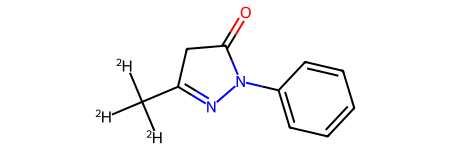

In [22]:
mol = Chem.MolFromSmiles('[2H]C([2H])([2H])C1=NN(c2ccccc2)C(=O)C1')
mol

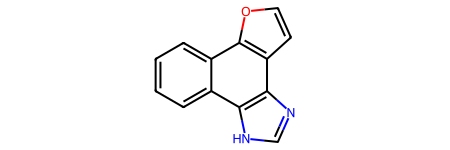

In [23]:
mol = Chem.MolFromSmiles('c1ccc2c(c1)c1[nH]cnc1c1ccoc21')
mol

1. 통일성을 위해 명시적으로 탄소에 붙은 H를 표기한 molecule 제거 => [2H]
2. protic 물질은 첨가제 목적에 맞지 않으니 제거 => [nH]

In [24]:
filtered_indices = df_unique[df_unique['Can_SMILES'].str.contains('H|\.')].index

df_unique.drop(filtered_indices, inplace=True)
df_unique

/tmp/ipykernel_26505/1975282920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.drop(filtered_indices, inplace=True)


,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
0,24,46225301,C16H12N4O2,292.29208,34,22,1.787810,-6.196032,-2.770119,3.425913,CC1=NN(C2=NC=C3C(=C12)C(=O)N(C3=O)C4=CC=CC=C4)C,Cc1nn(C)c2ncc3c(c12)C(=O)N(c1ccccc1)C3=O,0,0,0,0,0,0,0
1,39,46225638,C18H18O,250.33492,37,19,3.790826,-6.032764,-1.766019,4.266745,CC1=CC(=CC(=C1C)C)/C=C/C(=O)C2=CC=CC=C2,Cc1cc(/C=C/C(=O)c2ccccc2)cc(C)c1C,0,0,0,0,0,0,0
2,48,46225722,C15H11N3O4,297.26554,33,22,0.760276,-5.654526,-1.749692,3.904834,CC1=NC2=CC3=C(C=C2C(=O)N1/N=C/C4=CC=CO4)OCO3,Cc1nc2cc3c(cc2c(=O)n1/N=C/c1ccco1)OCO3,0,0,0,0,0,0,0
8,62,46225778,C11H11ClN2O2,238.67024,27,16,6.325738,-6.304878,-2.669437,3.635441,CN(C)CN1C2=C(C(=CC=C2)Cl)C(=O)C1=O,CN(C)CN1C(=O)C(=O)c2c(Cl)cccc21,0,0,0,0,0,0,0
9,63,46225791,C13H15ClN2O2,266.72340,33,18,6.369996,-6.095350,-2.655831,3.439519,CCN(CC)CN1C2=C(C(=CC=C2)Cl)C(=O)C1=O,CCN(CC)CN1C(=O)C(=O)c2c(Cl)cccc21,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108283,351679,118774686,C14H16N4O2,272.30244,36,20,2.525573,-5.991947,-0.386402,5.605545,C1CN(CC1OC2=CC=CC=C2)C(=O)CN3C=CN=N3,O=C(Cn1ccnn1)N1CCC(Oc2ccccc2)C1,0,0,0,0,0,0,0
108284,351680,118774692,C16H18N4O,282.34032,39,21,3.820336,-6.432771,-0.955120,5.477652,CC1=NOC(=N1)CN2CCC(CC2)(C#N)C3=CC=CC=C3,Cc1noc(CN2CCC(C#N)(c3ccccc3)CC2)n1,0,0,0,0,0,0,0
108285,351696,118774799,C12H20N4OS,268.37840,38,18,2.216076,-5.496700,-0.005442,5.491258,CSCCN1CCN(CC1)C(=O)CN2C=CC=N2,CSCCN1CCN(C(=O)Cn2cccn2)CC1,0,0,0,0,0,0,0
108286,351697,118774803,C13H22N6,262.35398,41,19,7.718982,-5.831400,0.157826,5.989226,CCCN1C=NN=C1CN(C)CC2=NN(C=C2)CC,CCCn1cnnc1CN(C)Cc1ccn(CC)n1,0,0,0,0,0,0,0


In [25]:
df_unique.to_csv('./PubChemQC_93683.csv')  #######파일명 수정 "PubChemQC__(new_df의 데이터 개수)"

In [4]:
df_unique = pd.read_csv('./PubChemQC_93683.csv')
df_unique

,Unnamed: 0.1,Unnamed: 0,i,molecular_formula,molecular_weight,atom_count,heavy_atom_count,total_dipole_moment,homo,lumo,gap,Isomeric_SMILES,Can_SMILES,delocal_charged,protic_N,alcohol,thiol,PH,small_ring,C_only
0,0,24,46225301,C16H12N4O2,292.29208,34,22,1.787810,-6.196032,-2.770119,3.425913,CC1=NN(C2=NC=C3C(=C12)C(=O)N(C3=O)C4=CC=CC=C4)C,Cc1nn(C)c2ncc3c(c12)C(=O)N(c1ccccc1)C3=O,0,0,0,0,0,0,0
1,1,39,46225638,C18H18O,250.33492,37,19,3.790826,-6.032764,-1.766019,4.266745,CC1=CC(=CC(=C1C)C)/C=C/C(=O)C2=CC=CC=C2,Cc1cc(/C=C/C(=O)c2ccccc2)cc(C)c1C,0,0,0,0,0,0,0
2,2,48,46225722,C15H11N3O4,297.26554,33,22,0.760276,-5.654526,-1.749692,3.904834,CC1=NC2=CC3=C(C=C2C(=O)N1/N=C/C4=CC=CO4)OCO3,Cc1nc2cc3c(cc2c(=O)n1/N=C/c1ccco1)OCO3,0,0,0,0,0,0,0
3,8,62,46225778,C11H11ClN2O2,238.67024,27,16,6.325738,-6.304878,-2.669437,3.635441,CN(C)CN1C2=C(C(=CC=C2)Cl)C(=O)C1=O,CN(C)CN1C(=O)C(=O)c2c(Cl)cccc21,0,0,0,0,0,0,0
4,9,63,46225791,C13H15ClN2O2,266.72340,33,18,6.369996,-6.095350,-2.655831,3.439519,CCN(CC)CN1C2=C(C(=CC=C2)Cl)C(=O)C1=O,CCN(CC)CN1C(=O)C(=O)c2c(Cl)cccc21,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93678,108283,351679,118774686,C14H16N4O2,272.30244,36,20,2.525573,-5.991947,-0.386402,5.605545,C1CN(CC1OC2=CC=CC=C2)C(=O)CN3C=CN=N3,O=C(Cn1ccnn1)N1CCC(Oc2ccccc2)C1,0,0,0,0,0,0,0
93679,108284,351680,118774692,C16H18N4O,282.34032,39,21,3.820336,-6.432771,-0.955120,5.477652,CC1=NOC(=N1)CN2CCC(CC2)(C#N)C3=CC=CC=C3,Cc1noc(CN2CCC(C#N)(c3ccccc3)CC2)n1,0,0,0,0,0,0,0
93680,108285,351696,118774799,C12H20N4OS,268.37840,38,18,2.216076,-5.496700,-0.005442,5.491258,CSCCN1CCN(CC1)C(=O)CN2C=CC=N2,CSCCN1CCN(C(=O)Cn2cccn2)CC1,0,0,0,0,0,0,0
93681,108286,351697,118774803,C13H22N6,262.35398,41,19,7.718982,-5.831400,0.157826,5.989226,CCCN1C=NN=C1CN(C)CC2=NN(C=C2)CC,CCCn1cnnc1CN(C)Cc1ccn(CC)n1,0,0,0,0,0,0,0


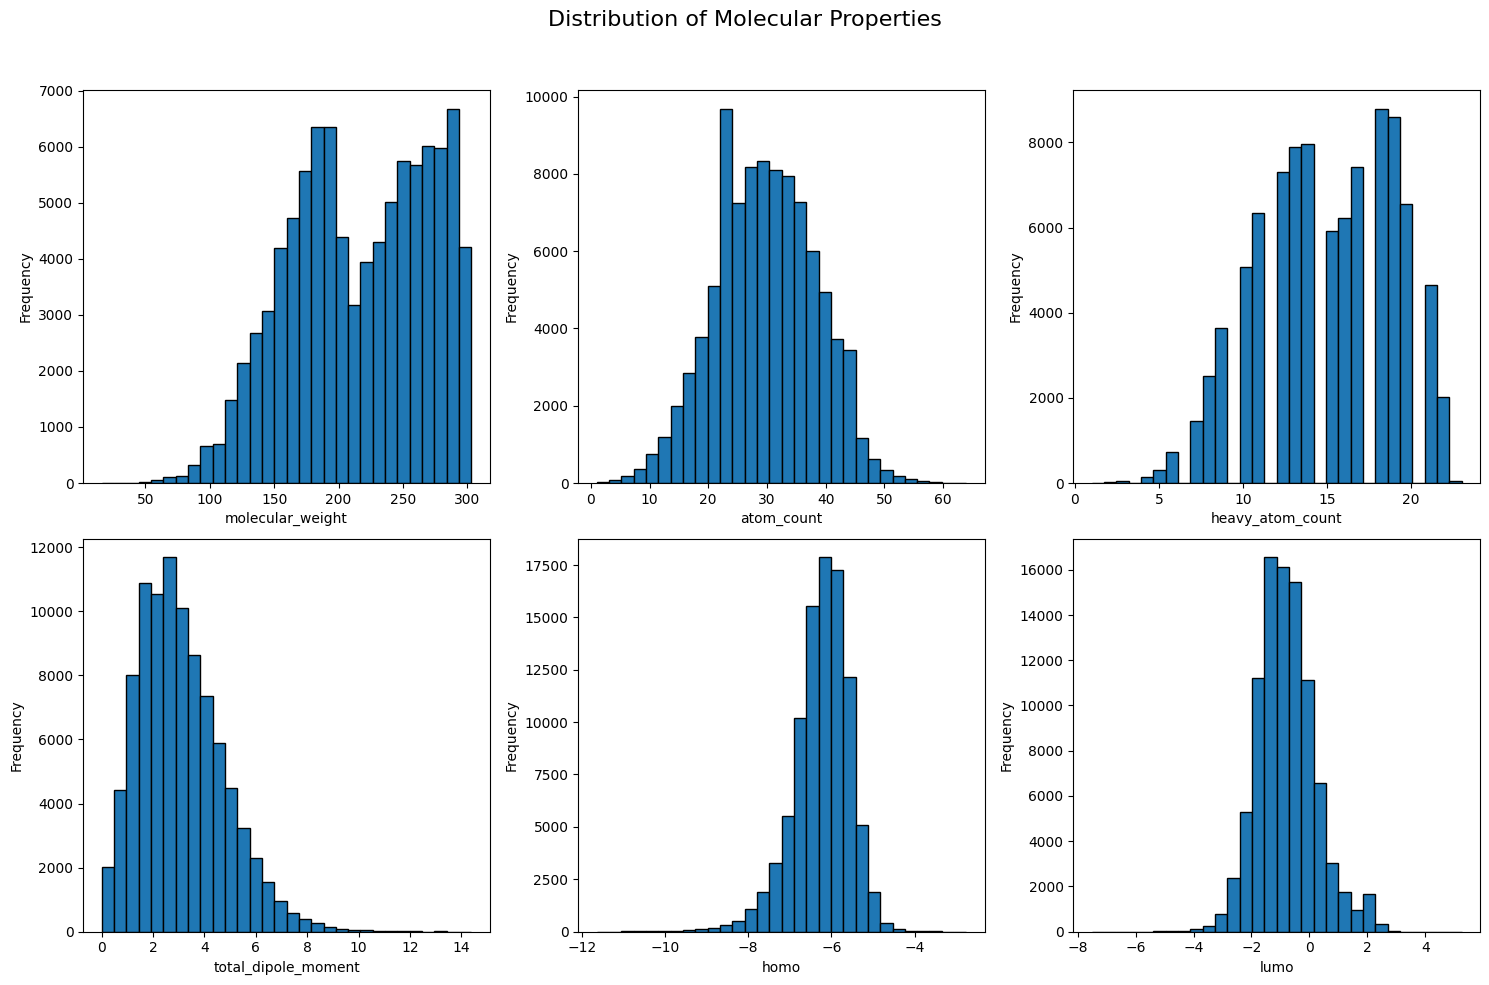

In [5]:
plot_distribution(df_unique, ["molecular_weight", "atom_count", "heavy_atom_count", "total_dipole_moment", "homo", "lumo"])

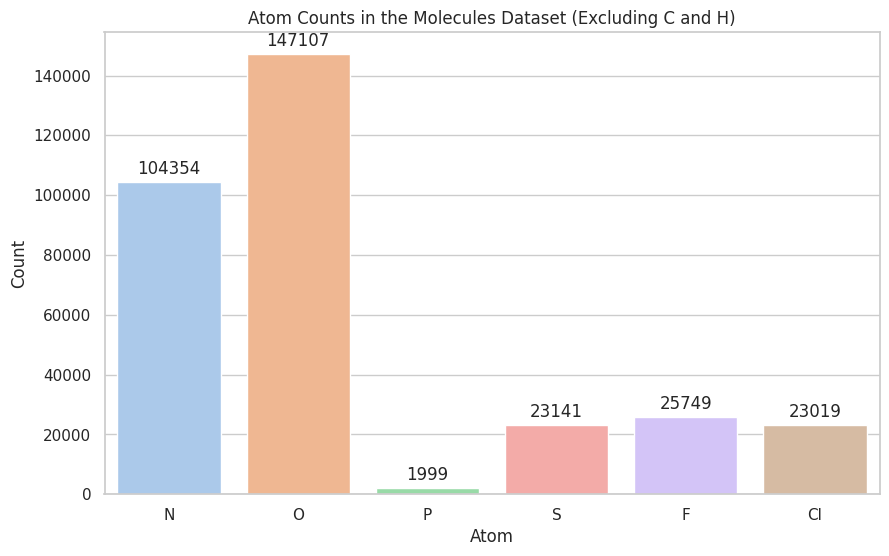

In [6]:
plot_atom_counts(df_unique)